## This notebook will run and analyse the Model for the Subway Data


## Random forest model training

In [76]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [77]:
##Writing installed packages to requirements.txt file
!pip freeze > subway_requirements.txt

In [78]:
#import the csv file needed to train the model
df=pd.read_csv('cleaned_busyness_data.csv')
df.head(10)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,station_busyness,hour,day,month,temperature,weather,rain_fall,snow_fall,station_category
0,1,1546315200,102,104,206,0,4,Tuesday,January,5.89,Rain,3.77,2.21,1
1,1,1546329600,96,51,147,0,8,Tuesday,January,11.18,Mist,0.00,0.12,1
2,1,1546344000,260,476,736,0,12,Tuesday,January,13.55,Rain,0.25,0.06,1
3,1,1546358400,540,496,1036,0,16,Tuesday,January,11.68,Rain,0.50,0.25,1
4,1,1546372800,602,250,852,0,20,Tuesday,January,3.70,Clouds,0.00,0.05,1
5,1,1546387200,159,147,306,0,0,Wednesday,January,2.05,Clouds,0.00,0.00,1
6,1,1546401600,48,38,86,0,4,Wednesday,January,-0.06,Clouds,0.00,0.00,1
7,1,1546416000,516,434,950,0,8,Wednesday,January,-2.08,Clear,0.00,0.00,1
8,1,1546430400,842,1351,2193,100,12,Wednesday,January,-1.89,Clear,0.00,0.00,4
9,1,1546444800,784,456,1240,10,16,Wednesday,January,0.04,Clear,0.00,0.00,1


In [79]:
#convert monthand day to numerical columns
df['month']=df['month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
                                'July':7,'August':8,'September':9,'October':10,'November':11,'December':12})
df['day']=df['day'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})


In [80]:
#convert weather and station busyness category to categorical columns
df['weather']=df['weather'].astype('category')

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287399 entries, 0 to 287398
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   remote_unit_id    287399 non-null  int64   
 1   time_stamp        287399 non-null  int64   
 2   entries           287399 non-null  int64   
 3   exits             287399 non-null  int64   
 4   sum_exit_entry    287399 non-null  int64   
 5   station_busyness  287399 non-null  int64   
 6   hour              287399 non-null  int64   
 7   day               287399 non-null  int64   
 8   month             287399 non-null  int64   
 9   temperature       287399 non-null  float64 
 10  weather           287399 non-null  category
 11  rain_fall         287399 non-null  float64 
 12  snow_fall         287399 non-null  float64 
 13  station_category  287399 non-null  int64   
dtypes: category(1), float64(3), int64(10)
memory usage: 28.8 MB


### Create a correlation matrix to see strength of correlations between feature pairs

/tmp/ipykernel_24905/2506163149.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mat=df.corr()


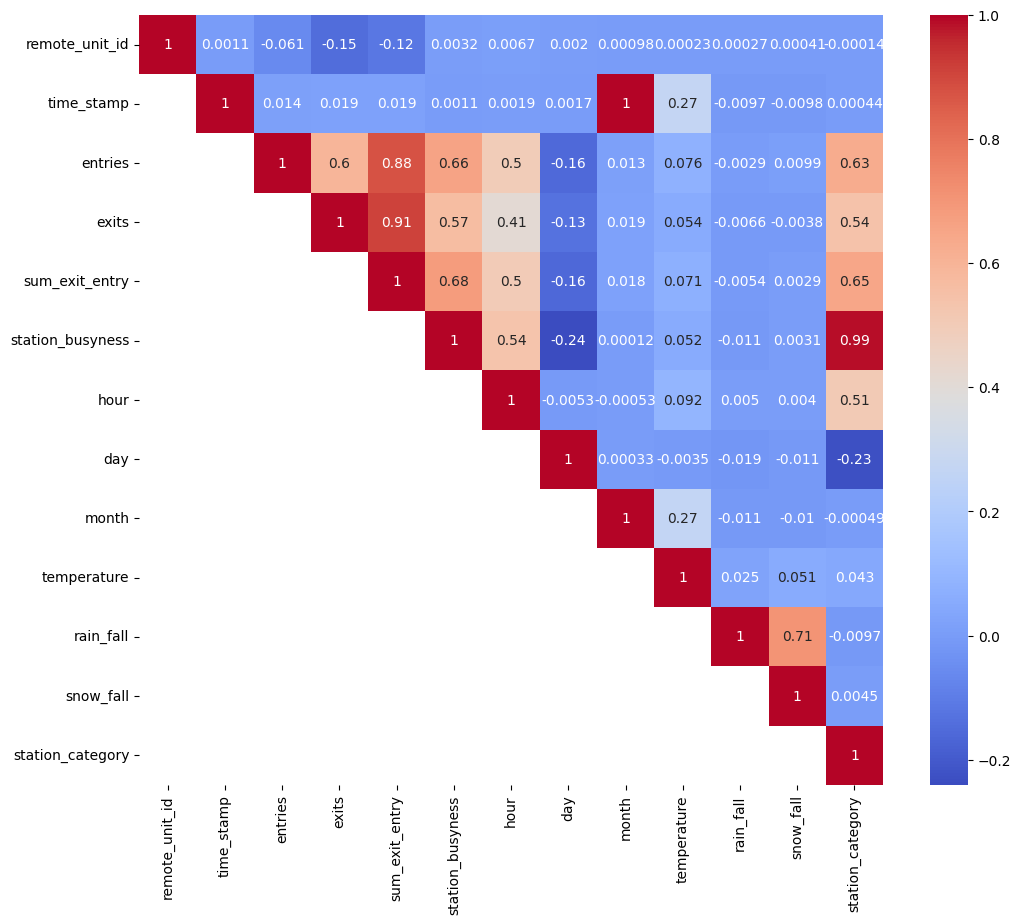

In [82]:
mat=df.corr()

# create a mask to drop the upper triangle
mask = np.triu(np.ones_like(mat, dtype=bool))

# apply the mask to the correlation matrix
mat = mat.where(mask)

fig, ax = plt.subplots(figsize=(12, 10))

sea.heatmap(mat, annot=True, cmap='coolwarm', ax=ax)

# show the plot
plt.show()

In [83]:
df.columns

Index(['remote_unit_id', 'time_stamp', 'entries', 'exits', 'sum_exit_entry',
       'station_busyness', 'hour', 'day', 'month', 'temperature', 'weather',
       'rain_fall', 'snow_fall', 'station_category'],
      dtype='object')

## One hot encoding for categorical features


In [84]:
one_hot = pd.get_dummies(df['weather'])
df = pd.concat([df, one_hot], axis = 1)

In [85]:
df.head()

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,station_busyness,hour,day,month,temperature,...,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm
0,1,1546315200,102,104,206,0,4,2,1,5.89,...,0,0,0,0,0,0,1,0,0,0
1,1,1546329600,96,51,147,0,8,2,1,11.18,...,0,0,0,0,0,1,0,0,0,0
2,1,1546344000,260,476,736,0,12,2,1,13.55,...,0,0,0,0,0,0,1,0,0,0
3,1,1546358400,540,496,1036,0,16,2,1,11.68,...,0,0,0,0,0,0,1,0,0,0
4,1,1546372800,602,250,852,0,20,2,1,3.70,...,0,1,0,0,0,0,0,0,0,0


## Functions to train the models

- Choose either the busyness percentages or the actual footfall values
- For Busyness percentages use random forest classifer, for actual footfall values use random forest regressor


In [86]:
def divide_data_station_busy(station_number, dataframe):
    df_inner = dataframe[dataframe['remote_unit_id'] == station_number].copy()
    #print(df_main)
    y=df_inner['station_busyness'].values
    #drop these values for query search
    df_inner=df_inner.drop(columns=['sum_exit_entry','station_busyness','remote_unit_id','station_category'])
    X = df_inner.values
    
    # Split the data into train and test sets- alter this later to be tested on last 3 months? 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #print(X_train, y_test)

    return df_inner, X_train, y_train, X_test, y_test

test_pred=[]
actual_pred=[]

test_mae_list = []
test_mape_list=[]
test_medae_list=[]
test_median_ape_list= []
test_rrmse_list=[]
test_score_list = []


def forest_training_model(train_x, train_y, test_x, test_y):
    #expirement with different parameters here
    forest = RandomForestRegressor(n_estimators=80, max_depth=10)
    forest = forest.fit(train_x, train_y)

    test_predictions = forest.predict(test_x)
    test_pred.append(test_predictions)
    actual_pred.append(test_y)

    test_mae = mean_absolute_error(test_y, test_predictions)
    test_mae_list.append(test_mae)

    test_mape = calculate_mape(test_y, test_predictions)
    test_mape_list.append(test_mape)

    test_medae = median_absolute_error(test_y, test_predictions)
    test_medae_list.append(test_medae)

    test_median_ape = median_absolute_percentage_error(test_y, test_predictions)
    test_median_ape_list.append(test_median_ape)

    test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
    test_rrmse = test_rmse / np.mean(test_y)
    test_rrmse_list.append(test_rrmse)

    test_r2 = r2_score(test_y, test_predictions)
    test_score_list.append(test_r2)

    return forest


def calculate_mape(actual, predicted):
    # Calculate MAPE while handling zero values in actual
    mape = np.mean(np.abs((actual - predicted) / np.where(actual == 0, 1, actual)))
    return mape

def median_absolute_error(actual, predicted):
    absolute_errors = np.abs(actual - predicted)
    medae = np.median(absolute_errors)
    return medae

def median_absolute_percentage_error(actual,predicted):
    absolute_percentage_errors = np.abs((actual - predicted) / np.where(actual == 0, 1, actual))
    median_ape = np.median(absolute_percentage_errors)
    return median_ape


## Description of the error metrics:

### Mean Absolute Error:
- This is the average of the absolute value of the errors between the predicted values and the actual values. This is the most intuitive of the metrics and is the easiest to understand. However, it is also the most sensitive to outliers.

### Mean Absolute Percentage Error:
- This is the average of the absolute percentage errors between the predicted values and the actual values. This metric is similar to the MAE, but it is a relative metric which is useful for comparing the performance of these models.

### Median Absolute Error:
- This is the median of the absolute value of the errors between the predicted values and the actual values. This metric is similar to the MAE, but it is more robust to outliers.
### Median Absolute Percentage Error:
- This is the median of the absolute percentage errors between the predicted values and the actual values. This metric is similar to the MAPE, but it is more robust to outliers.

### Relative Root Mean Squared Error:
- This is the RMSE divided by the standard deviation of the dependent variable. This metric is similar to the RMSE, but it is a relative metric which is useful for comparing the performance of these models.

### R2 Score:
- This is the proportion of the variance in the dependent variable that is predictable from the independent variables. This metric is useful for comparing the performance of these models.


## Function to save the models

In [96]:
def save_model_station_busy(model, station_number):
    filename = f'/home/cian/Documents/GitHub/NYSeeNow-ML/SubwayData/station_busy/s_busy_model_{station_number}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

### Clean the pickle dataframe 
- In order to reduce the size and time taken to run the models


In [88]:
df.drop(columns=['weather'], inplace=True)
df_pickle=df.copy()


In [89]:
df_pickle.columns

Index(['remote_unit_id', 'time_stamp', 'entries', 'exits', 'sum_exit_entry',
       'station_busyness', 'hour', 'day', 'month', 'temperature', 'rain_fall',
       'snow_fall', 'station_category', 'Clear', 'Clouds', 'Drizzle', 'Fog',
       'Haze', 'Mist', 'Rain', 'Smoke', 'Snow', 'Thunderstorm'],
      dtype='object')

### Drop features of least importance: thunderstorm, haze, fog, drizzle and smoke


In [90]:
#drop entries exits and timestamp from the pickle model, we wont know these to give to it, 
#and for each pickle one it cant have the other perctenage busyness

df_pickle.drop(columns=['time_stamp', 'entries', 'exits','Thunderstorm', 'Haze', 'Fog','Drizzle', 'Smoke'],axis=1,inplace=True)


In [91]:
df_pickle.columns

Index(['remote_unit_id', 'sum_exit_entry', 'station_busyness', 'hour', 'day',
       'month', 'temperature', 'rain_fall', 'snow_fall', 'station_category',
       'Clear', 'Clouds', 'Mist', 'Rain', 'Snow'],
      dtype='object')

In [92]:
df_pickle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287399 entries, 0 to 287398
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   remote_unit_id    287399 non-null  int64  
 1   sum_exit_entry    287399 non-null  int64  
 2   station_busyness  287399 non-null  int64  
 3   hour              287399 non-null  int64  
 4   day               287399 non-null  int64  
 5   month             287399 non-null  int64  
 6   temperature       287399 non-null  float64
 7   rain_fall         287399 non-null  float64
 8   snow_fall         287399 non-null  float64
 9   station_category  287399 non-null  int64  
 10  Clear             287399 non-null  uint8  
 11  Clouds            287399 non-null  uint8  
 12  Mist              287399 non-null  uint8  
 13  Rain              287399 non-null  uint8  
 14  Snow              287399 non-null  uint8  
dtypes: float64(3), int64(7), uint8(5)
memory usage: 23.3 MB


In [93]:
#count the occurances of 1 in the following columns: Clear, Clouds, Drizzle, Fog etc
occurrences = df[['Clear', 'Clouds', 'Mist','Rain','Snow']].sum(axis=0)
occurrences


Clear     133598
Clouds     75600
Mist       17562
Rain       48114
Snow        3960
dtype: int64

## Execute the models

### Get station numbers

In [94]:
df_static = pd.read_csv('cleaned_station_data.csv')
check=df_static["remote_unit_id"]
order=check.tolist()
#now order the stations
order.sort()
#order
len(order)

143

## Code that runs and saves the models

- Keep the save commented to save writing the new models again

In [95]:
for station_number in df['remote_unit_id'].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data_station_busy(station_number, df_pickle)
    #print(df_station)
    model = forest_training_model(x_train, y_train, x_test, y_test)
    save_model_station_busy(model, station_number)

    #get importances
    station_importance = pd.DataFrame({'feature': df_station.columns, 'importance':model.feature_importances_})
    station_importance.sort_values('importance', ascending=False)

    #have a mean importance value for each feature
    station_importance['importance'].mean()
    
#print average scores
print(f"Average Mean Absolute Error : {np.mean(test_mae_list):.6f}")
print(f"Average Mean Absolute Percentage Error : {np.mean(test_mape_list):.6f}")
print(f"Average Median Absolute Error : {np.mean(test_medae_list):.6f}")
print(f"Average Median Absolute Percentage Error : {np.mean(test_median_ape_list):.6f}")
print(f"Average Relative Root Mean Squared Error : {np.mean(test_rrmse_list):.6f}")
print(f"R squared test score : {np.mean(test_score_list):.6f}")


FileNotFoundError: [Errno 2] No such file or directory: '/home/cian/Documents/GitHub/NYSeeNow/NYSeeNow-ML/SubwayData/station_busy/s_busy_model_1.pkl'

In [ ]:
#compare the actual values with the predicted values:
df_compare = pd.DataFrame({'Actual': actual_pred, 'Predicted': test_pred})

In [ ]:
df_compare.head(50)

,Actual,Predicted
0,"[0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0,...","[25.404594280240833, 0.0, 13.99091478696742, 0..."
1,"[20, 0, 10, 10, 50, 0, 100, 0, 0, 60, 0, 10, 7...","[27.111804781380137, 0.6041666666666667, 6.717..."
2,"[0, 100, 90, 0, 100, 0, 0, 100, 0, 0, 0, 0, 10...","[1.1225400714379155, 77.27440377862591, 75.158..."
3,"[0, 10, 0, 0, 100, 0, 20, 100, 0, 0, 40, 0, 10...","[6.788344559314953, 40.579166666666666, 0.0, 0..."
4,"[0, 20, 100, 0, 0, 20, 0, 0, 50, 0, 100, 0, 0,...","[0.0, 25.11675824175824, 75.23958333333334, 0...."
5,"[0, 0, 20, 0, 20, 0, 50, 100, 0, 0, 0, 100, 0,...","[0.0, 0.0, 28.798183210503176, 40.003316107818..."
6,"[0, 0, 0, 90, 0, 80, 0, 0, 100, 0, 0, 0, 0, 0,...","[21.10033156686194, 0.0, 0.0, 30.2127949165819..."
7,"[100, 100, 0, 100, 0, 100, 0, 0, 0, 0, 0, 100,...","[98.46412631495807, 89.54985174323885, 3.21624..."
8,"[0, 0, 0, 0, 0, 0, 0, 100, 0, 100, 0, 100, 0, ...","[6.015833265753104, 0.0, 0.0, 0.0, 5.375, 0.0,..."
9,"[100, 10, 0, 0, 100, 0, 100, 100, 70, 0, 100, ...","[97.65455333686702, 13.278263911615207, 0.0, 0..."


## Lets analyse this further- use data hmw2

### Feature Importance for Random Forest for station busyness

In [ ]:
#change importance column to % and no decimal places
station_importance['importance %'] = station_importance['importance'].apply(lambda x: round(x*100, 2))
station_importance.sort_values('importance', ascending=False)

,feature,importance,importance %
0,hour,0.469352,46.94
1,day,0.309664,30.97
3,temperature,0.112457,11.25
2,month,0.056986,5.70
5,snow_fall,0.017705,1.77
4,rain_fall,0.011639,1.16
7,Clouds,0.009454,0.95
6,Clear,0.005875,0.59
8,Mist,0.002976,0.30
10,Snow,0.002079,0.21


In [ ]:
# Lets explore the data
# filter the DataFrame to only include rows where 'Monday' equals 1
df_mondays = df[df['day'] == 1]
#pick one station
df_mondays_1 = df_mondays[df_mondays['remote_unit_id'] == 1]
df_mondays_1.head()

,remote_unit_id,time_stamp,entries,exits,surrounding_area_busyness,station_busyness,hour,day,month,temperature,...,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm


### Make some plots to better understand the busyness for each station

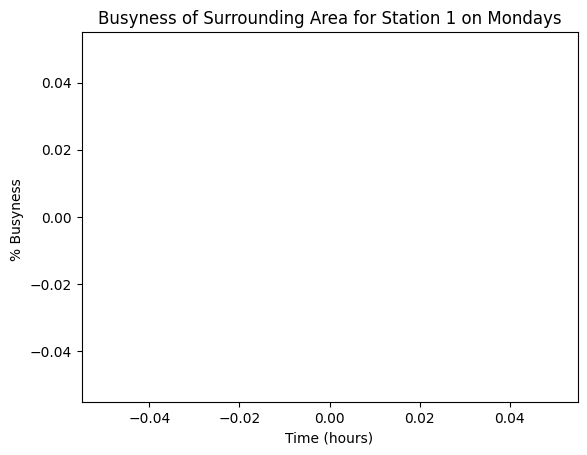

In [ ]:
# create scatter plot using the filtered DataFrame
plt.scatter(df_mondays_1['hour'], df_mondays_1['surrounding_area_busyness'])
plt.title("Busyness of Surrounding Area for Station 1 on Mondays")
plt.ylabel("% Busyness ")
plt.xlabel("Time (hours)")
plt.show()


### Description of the models:
- I have made two busyness prediciton models that only need the remote unit id, which can be easily mapped from the lookup table
- Choose surrounding area, or station busyness prediction by selecting the correct folder
- Select the Remote Unit id using the cleaned_station_data.csv file
- The model also requires the following to get the prediciton:
- hour as an int with 0 being midnight, 1 being 1AM etc
- day as an int with 1 being Monday etc
- month as int with 1 being January etc
- temperature as float in Celsius
- rain_fall as float in mm per hour
- snow_fall as float in mm per hour
- Clear as a int, 1 or  0
- Clouds as a int, 1 or  0
- Same for Drizzle, Fog, Haze, Mist, Rain, Smoke, Snow and Thunderstorm

### Plots of some stations over a week

In [ ]:
len(df)

297835

In [ ]:

def average_station_busyness(numb):
    # filter the DataFrame to only include data for one station
    df_station = df[df['remote_unit_id'] == numb]

    # calculate the mean availability percentage for each hour of the day and day of the week
    df_hourly = df_station.groupby(['day','hour'])['station_busyness'].mean()
    df_hourly.dropna(inplace=True)

    # plot a line plot of the data
    df_hourly.plot(kind='line', figsize=(10,8))

    plt.title(f"Average Station Busyness for {numb} over the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Station Busyness")
    plt.ylim(0, 100)
    plt.show()


def average_area_busyness(numb):
    # filter the DataFrame to only include data for one station
    df_station = df[df['remote_unit_id'] == numb]

    # calculate the mean availability percentage for each hour of the day and day of the week
    df_hourly = df_station.groupby(['day','hour'])['surrounding_area_busyness'].mean()
    df_hourly.dropna(inplace=True)

    # plot a line plot of the data
    df_hourly.plot(kind='line', figsize=(10,8))

    plt.title(f"Average Area Busyness for {numb} over the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Station Busyness")
    plt.ylim(0, 100)
    plt.show()




In [ ]:
# we just need to create a collect csv files for both and put them in here
df_static = pd.read_csv('cleaned_station_data.csv')
df_static.head()

,station_name,lat,lon,remote_unit_id,short_name
0,Lexington Av/59 St,40.762660,-73.967258,16,LEXINGTON-53 ST
1,Lexington Av/59 St,40.762660,-73.967258,17,LEXINGTON-53 ST
2,Lexington Av/59 St,40.762660,-73.967258,50,59 ST
3,Lexington Av/59 St,40.762660,-73.967258,51,59 ST
4,5 Av/59 St,40.764811,-73.973347,79,5 AVE-59 ST


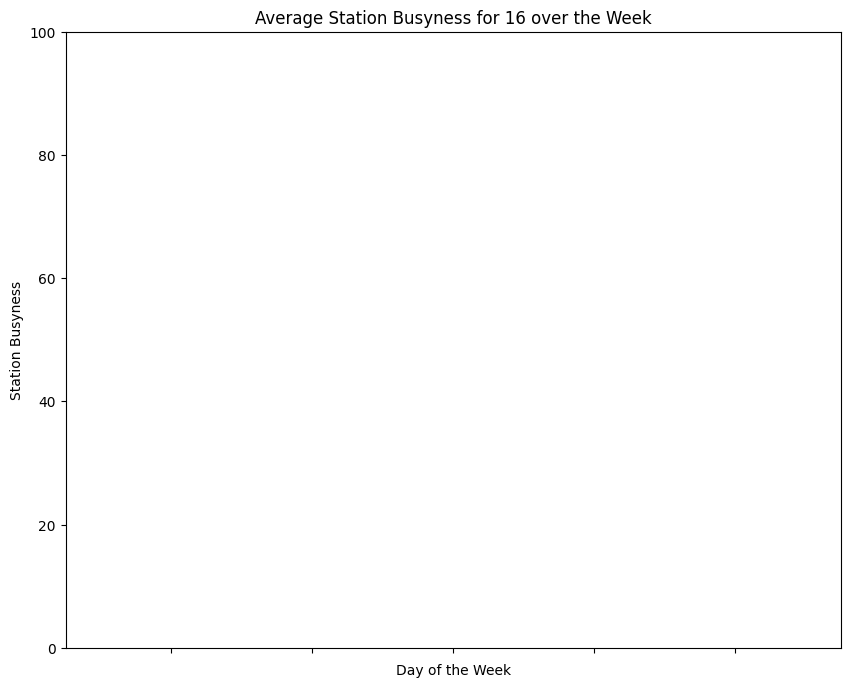

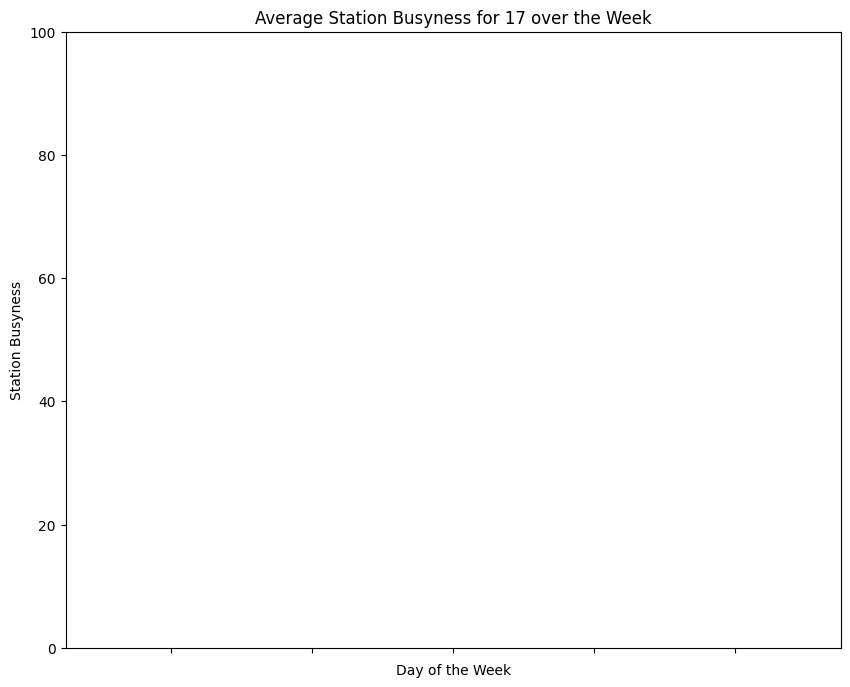

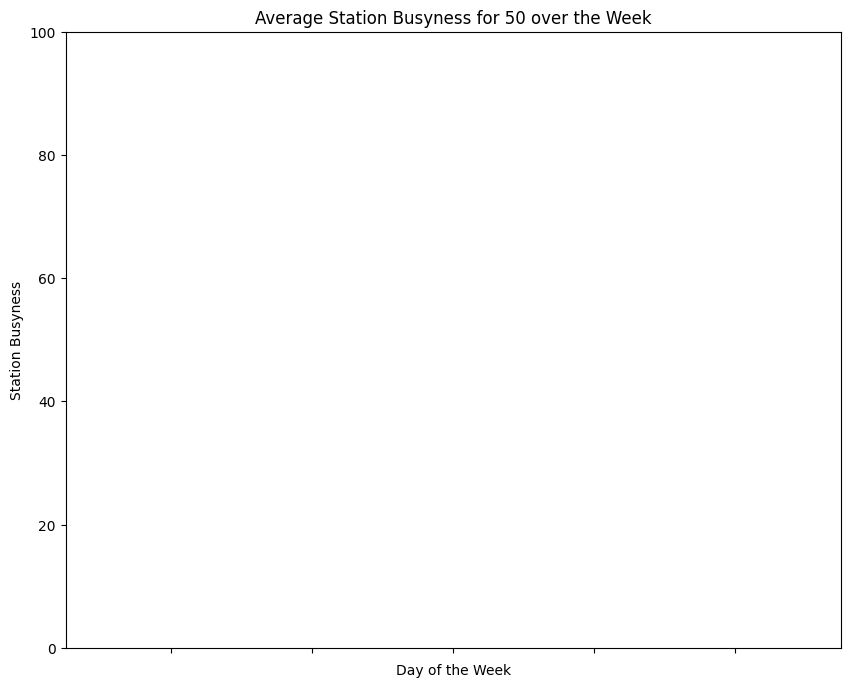

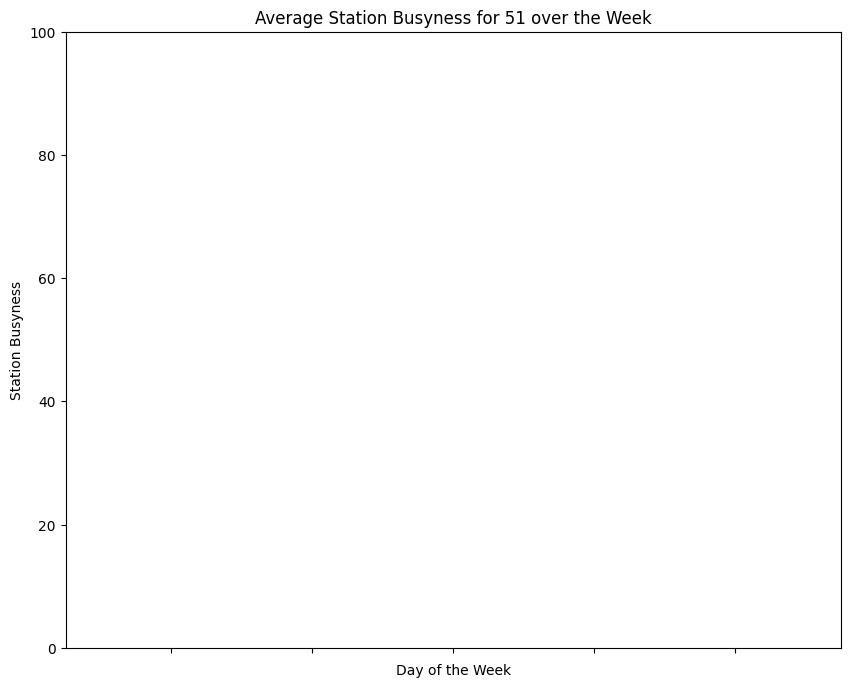

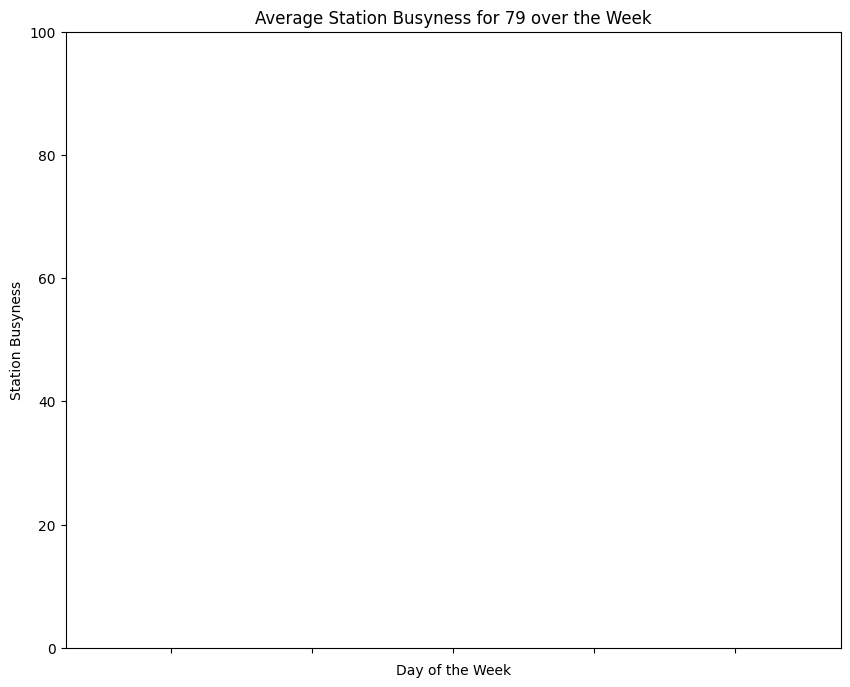

In [ ]:
#pick some stations to plot
length = len(df_static['remote_unit_id'])
for i in range(0, 5):
    numb=df_static['remote_unit_id'][i]
    average_station_busyness(numb)

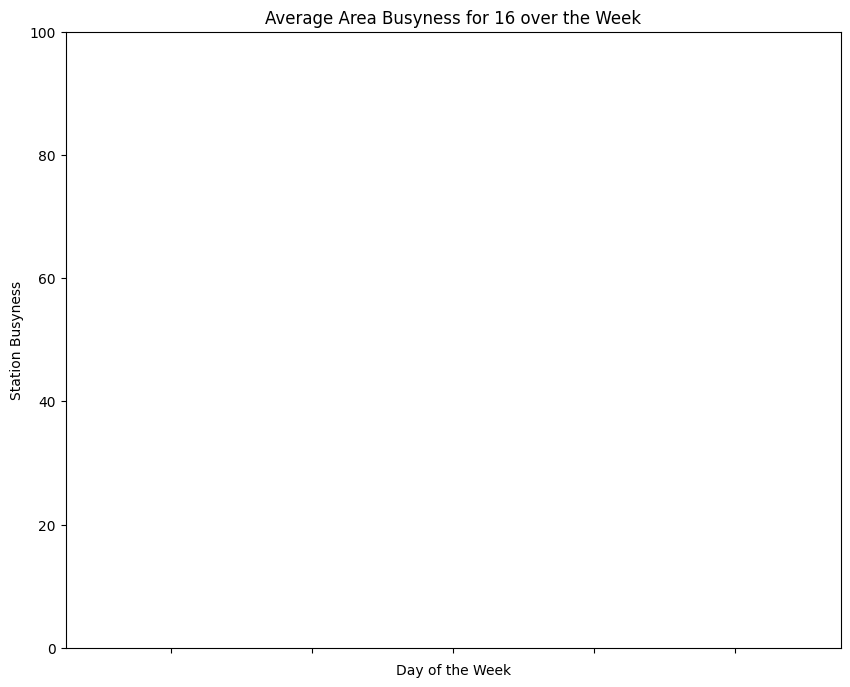

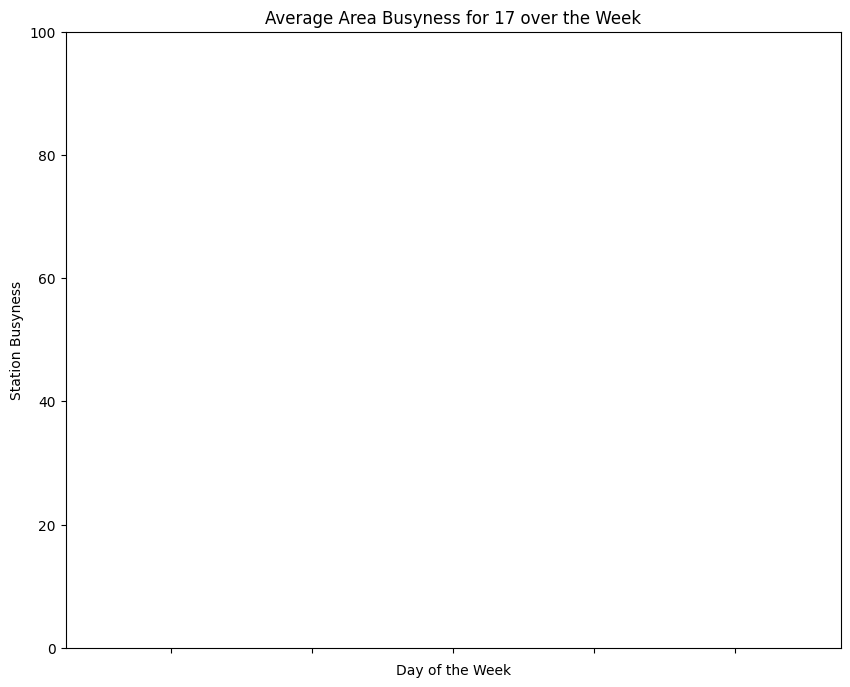

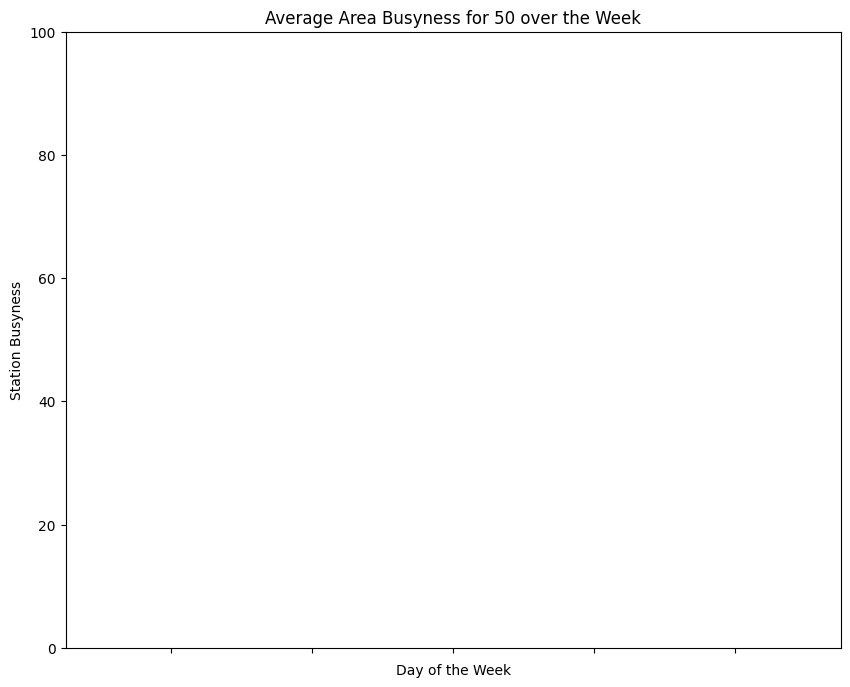

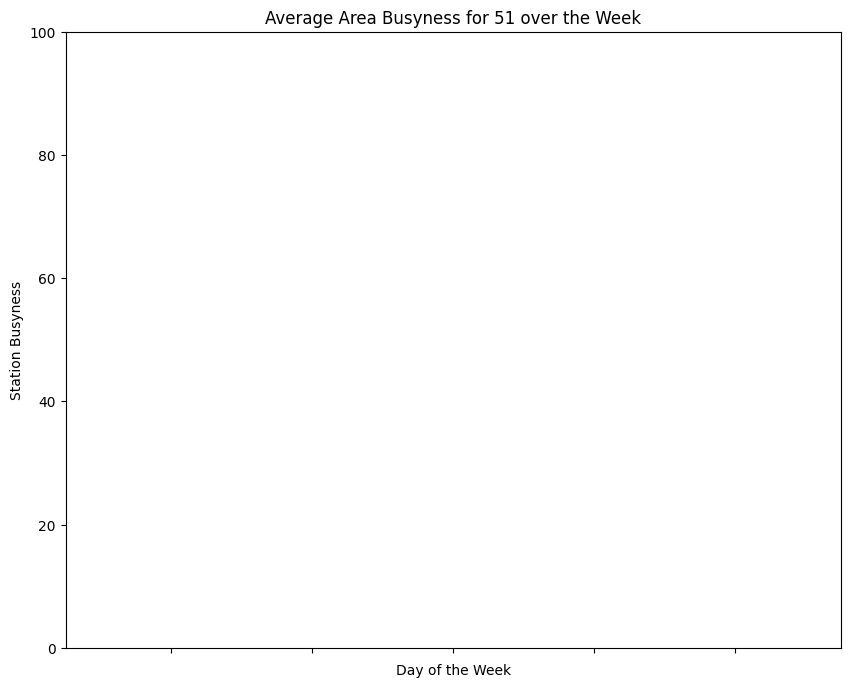

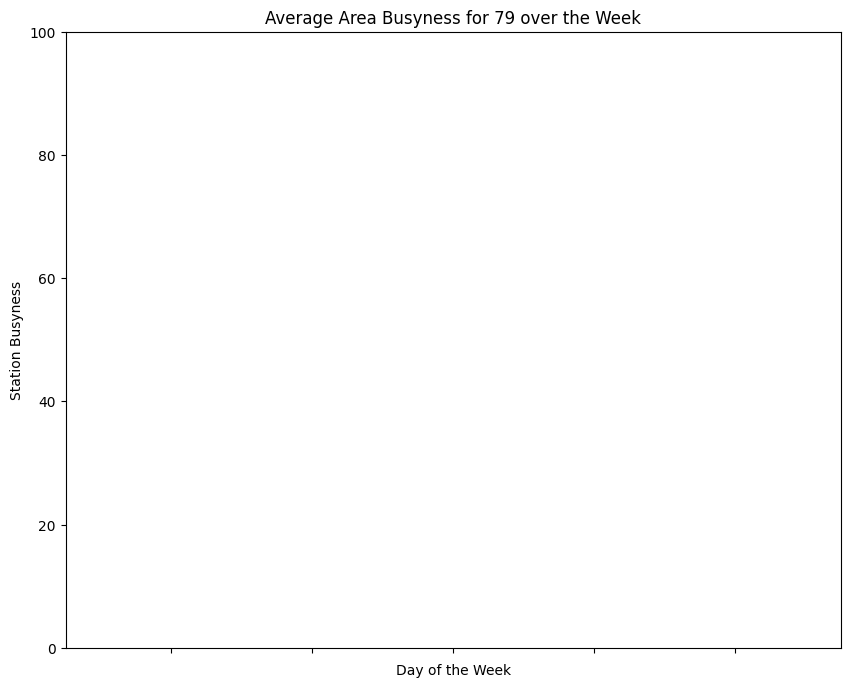

In [ ]:
#pick some stations to plot
length = len(df_static['remote_unit_id'])
for i in range(0, 5):
    numb=df_static['remote_unit_id'][i]
    average_area_busyness(numb)